<a href="https://colab.research.google.com/github/RitamRoa/research-search/blob/main/research-search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Analyze the research papers in the CSV file "/content/dblp-v10.csv" using NLP to classify them into categories, train a classification model, generate a confusion matrix, and build a system to retrieve papers based on user queries like "machine learning papers".

## Load the data

### Subtask:
Load the research paper data from the provided CSV file into a pandas DataFrame.


**Reasoning**:
Import pandas and load the CSV file into a DataFrame, then display the first 5 rows.



In [1]:
import pandas as pd

df = pd.read_csv('/content/dblp-v10.csv')
display(df.head())

ParserError: Error tokenizing data. C error: EOF inside string starting at row 81160

**Reasoning**:
The previous attempt to read the CSV failed due to a parsing error. To handle this, I will try reading the CSV with the `low_memory` option set to False and also specify the `engine` as 'python' which is more robust to parsing errors, although potentially slower.



In [2]:
df = pd.read_csv('/content/dblp-v10.csv', low_memory=False, engine='python')
display(df.head())

ValueError: The 'low_memory' option is not supported with the 'python' engine

**Reasoning**:
The previous attempt failed because `low_memory` is not supported with the 'python' engine. I will try reading the CSV using only the 'python' engine to handle the parsing error, as this engine is less prone to issues with irregular lines.



In [3]:
df = pd.read_csv('/content/dblp-v10.csv', engine='python')
display(df.head())

ParserError: unexpected end of data

**Reasoning**:
The CSV file seems to have issues that even the 'python' engine cannot handle directly, resulting in an "unexpected end of data" error. To work around this, I will try reading the file line by line, and then use pandas to read the data from the list of lines, skipping bad lines.



In [4]:
import csv
from io import StringIO

with open('/content/dblp-v10.csv', 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

# Find the header
header = lines[0]
data_lines = lines[1:]

# Attempt to read with pandas from the processed lines, skipping bad lines
try:
    df = pd.read_csv(StringIO("".join([header] + data_lines)), on_bad_lines='skip')
    display(df.head())
except Exception as e:
    print(f"An error occurred: {e}")
    # Fallback: Try reading with a different delimiter or quoting if skipping lines doesn't work
    try:
        df = pd.read_csv(StringIO("".join([header] + data_lines)), on_bad_lines='skip', delimiter=',', quotechar='"')
        display(df.head())
    except Exception as e:
        print(f"A second error occurred: {e}")
        # If all attempts fail, we might need to inspect the data manually or try a different approach
        df = None


An error occurred: Error tokenizing data. C error: EOF inside string starting at row 83290
A second error occurred: Error tokenizing data. C error: EOF inside string starting at row 83290


**Reasoning**:
Reading the file line by line and using `on_bad_lines='skip'` did not resolve the `ParserError`. The error "EOF inside string" suggests an issue with quoted fields containing newlines or the file being truncated. A more robust approach for such corrupted files is to use a more flexible CSV reader or try to identify the problematic lines and clean them. Given the limitations in interactively debugging the file content, and the persistent `ParserError` even with the Python engine and skipping bad lines, I will try a different strategy using `csv.reader` to read the file line by line and then manually construct the DataFrame. This approach allows for more control over how lines are parsed and can potentially bypass the limitations of `pandas.read_csv` with this specific file.



In [5]:
import csv

data = []
header = None
with open('/content/dblp-v10.csv', 'r', encoding='utf-8', errors='ignore') as f:
    csv_reader = csv.reader(f)
    header = next(csv_reader) # Read the header
    for i, row in enumerate(csv_reader):
        # Simple check to see if the number of columns matches the header
        # This might not catch all errors but can help with some malformed rows
        if len(row) == len(header):
            data.append(row)
        else:
            # Optional: print line number and content of problematic rows for debugging
            # print(f"Skipping malformed row {i+2}: {row}")
            pass

if header and data:
    df = pd.DataFrame(data, columns=header)
    display(df.head())
else:
    print("Could not load data.")
    df = None


,abstract,authors,n_citation,references,title,venue,year,id
0,"In this paper, a robust 3D triangular mesh wat...","['S. Ben Jabra', 'Ezzeddine Zagrouba']",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",A new approach of 3D watermarking based on ima...,international symposium on computers and commu...,2008,4ab3735c-80f1-472d-b953-fa0557fed28b
1,We studied an autoassociative neural network w...,"['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq...",50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",Attractor neural networks with activity-depend...,Neurocomputing,2007,4ab39729-af77-46f7-a662-16984fb9c1db
2,It is well-known that Sturmian sequences are t...,"['Genevi eve Paquin', 'Laurent Vuillon']",50,"['1c655ee2-067d-4bc4-b8cc-bc779e9a7f10', '2e4e...",A characterization of balanced episturmian seq...,Electronic Journal of Combinatorics,2007,4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de
3,One of the fundamental challenges of recognizi...,"['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']",221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",Exploring the space of a human action,international conference on computer vision,2005,4ab3a98c-3620-47ec-b578-884ecf4a6206
4,This paper generalizes previous optimal upper ...,"['Efraim Laksman', 'Håkan Lennerstad', 'Magnus...",0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",Generalized upper bounds on the minimum distan...,Ima Journal of Mathematical Control and Inform...,2015,4ab3b585-82b4-4207-91dd-b6bce7e27c4e


## Explore the data

### Subtask:
Examine the structure and content of the DataFrame to understand the available information (e.g., paper titles, abstracts, categories, etc.).


**Reasoning**:
Examine the structure and content of the DataFrame to understand the available information by displaying information about the DataFrame, descriptive statistics, the head and tail, missing values, and unique values for categorical columns.



In [6]:
df.info()
display(df.describe())
display(df.head())
display(df.tail())
display(df.isnull().sum())

# Explore unique values and their counts for 'venue' and 'year'
display(df['venue'].value_counts().head())
display(df['year'].value_counts().head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84703 entries, 0 to 84702
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   abstract    84703 non-null  object
 1   authors     84703 non-null  object
 2   n_citation  84703 non-null  object
 3   references  84703 non-null  object
 4   title       84703 non-null  object
 5   venue       84703 non-null  object
 6   year        84703 non-null  object
 7   id          84703 non-null  object
dtypes: object(8)
memory usage: 5.2+ MB


,abstract,authors,n_citation,references,title,venue,year,id
count,84703,84703,84703,84703,84703,84703,84703,84703
unique,81519,82189,1104,76345,84697,2616,68,84703
top,,"['Irith Pomeranz', 'Sudhakar M. Reddy']",50,[],Parameter identifiability of multichannel ARMA...,,2009,66ca6dd3-554e-48db-befa-694600d6a083
freq,3144,29,28860,5826,2,7645,8295,1


,abstract,authors,n_citation,references,title,venue,year,id
0,"In this paper, a robust 3D triangular mesh wat...","['S. Ben Jabra', 'Ezzeddine Zagrouba']",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",A new approach of 3D watermarking based on ima...,international symposium on computers and commu...,2008,4ab3735c-80f1-472d-b953-fa0557fed28b
1,We studied an autoassociative neural network w...,"['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq...",50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",Attractor neural networks with activity-depend...,Neurocomputing,2007,4ab39729-af77-46f7-a662-16984fb9c1db
2,It is well-known that Sturmian sequences are t...,"['Genevi eve Paquin', 'Laurent Vuillon']",50,"['1c655ee2-067d-4bc4-b8cc-bc779e9a7f10', '2e4e...",A characterization of balanced episturmian seq...,Electronic Journal of Combinatorics,2007,4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de
3,One of the fundamental challenges of recognizi...,"['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']",221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",Exploring the space of a human action,international conference on computer vision,2005,4ab3a98c-3620-47ec-b578-884ecf4a6206
4,This paper generalizes previous optimal upper ...,"['Efraim Laksman', 'Håkan Lennerstad', 'Magnus...",0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",Generalized upper bounds on the minimum distan...,Ima Journal of Mathematical Control and Inform...,2015,4ab3b585-82b4-4207-91dd-b6bce7e27c4e


,abstract,authors,n_citation,references,title,venue,year,id
84698,Many software applications produced today have...,"['María José Suárez-Cabal', 'Javier Tuya']",4,"['1428f757-51e1-4de7-bb58-91917c0390b5', '1528...",Improvement of test data by measuring SQL stat...,,2003,66ca3897-1b91-4429-8b17-2cc9f7b2477e
84699,Recent declines in the average length of time ...,['Matthew Bidwell'],50,[],What Happened to Long-Term Employment? The Rol...,Organization Science,2013,66ca4dba-19ac-4d25-b9d4-b1cc6fec1ec8
84700,Bismuth substituted iron garnets (BIGs) are ma...,"['Sasha Kemmet', 'Greg Bonett', 'Mani Mina', '...",0,[],Fiber based measurements of domain characteris...,electro information technology,2008,66ca5e1b-882d-476a-b216-c756d1f1892f
84701,"Over the past six years, Seattle University's ...","['Roshanak Roshandel', 'Jeff Gilles', 'Richard...",50,"['218db9c7-558f-4e4a-b42c-ac2bb8ee3090', '6f16...",Using community-based projects in software eng...,,2011,66ca6283-c944-49b3-802b-d443a3bfa90a
84702,The aim of this work is to integrate the ideas...,"['Liguo Deng', 'Yunpeng Cai', 'Chen Wang', 'Ya...",50,"['170314d8-adf1-471b-b8c8-1a503a377bd2', '1d3e...",Fuzzy Temporal Logic on Fuzzy Temporal Constra...,fuzzy systems and knowledge discovery,2009,66ca6dd3-554e-48db-befa-694600d6a083


,0
abstract,0
authors,0
n_citation,0
references,0
title,0
venue,0
year,0
id,0


,count
venue,
,7645
"international conference on acoustics, speech, and signal processing",1581
international conference on robotics and automation,1380
Bioinformatics,919
international conference on communications,881


,count
year,
2009,8295
2008,7598
2011,6858
2007,6426
2010,5641


## Define classification categories

### Subtask:
Based on the data and your needs, define the categories into which the research papers will be classified.


**Reasoning**:
Analyze the content of 'abstract', 'title', and 'venue' columns to identify recurring themes and define categories.



In [7]:
# Sample a smaller portion of the data for initial theme identification
sample_df = df.sample(n=1000, random_state=42)

# Inspect abstracts and titles
print("Sample Abstracts and Titles:")
for index, row in sample_df.iterrows():
    print(f"Title: {row['title']}")
    print(f"Abstract: {row['abstract']}")
    print("-" * 20)

# Inspect venues and their frequencies in the sample
print("\nSample Venue Frequencies:")
print(sample_df['venue'].value_counts().head(20))

# Based on the inspection, define potential categories
categories = {
    "Computer Science - General": ["computer science", "computing", "systems", "software"],
    "Artificial Intelligence & Machine Learning": ["machine learning", "artificial intelligence", "ai", "neural network", "deep learning", "computer vision", "natural language processing", "nlp"],
    "Data Science & Databases": ["data science", "database", "data mining", "big data", "information retrieval", "knowledge discovery"],
    "Theory & Algorithms": ["algorithm", "theory", "mathematics", "optimization", "graph theory"],
    "Networking & Communications": ["network", "communication", "wireless", "internet", "protocol"],
    "Security & Privacy": ["security", "privacy", "cryptography", "authentication", "cybersecurity"],
    "Human-Computer Interaction": ["human-computer interaction", "hci", "user interface", "usability"],
    "Computer Graphics & Visualization": ["computer graphics", "visualization", "image processing"],
    "Hardware & Architecture": ["architecture", "hardware", "circuit", "VLSI"]
}

# Print the defined categories
print("\nDefined Categories:")
for category, keywords in categories.items():
    print(f"- {category}: Keywords/Themes include {', '.join(keywords)}")

Sample Abstracts and Titles:
Title: Interference mitigation using Widely Linear arrays
Abstract: Widely Linear Processing (WLP), proposed by Brown and Crane in 1969, has recently received a great deal of attention, in particular due to its potential of application in some important problems in array processing. The present work investigates the implementation of the linearly constrained minimum variance (LCMV) algorithm proposed by Frost in the context of widely and strictly linear processing. The results are compared with those obtained via MVDR widely and strictly linear processing.
--------------------
Title: A first investigation of Sturmian trees
Abstract: We consider Sturmian trees as a natural generalization of Sturmian words. A Sturmian tree is a tree having n+1 distinct subtrees of height n for each n. As for the case of words, Sturmian trees are irrational trees of minimal complexity. We give various examples of Sturmian trees, and we characterize one family of Sturmian trees

## Label the data

### Subtask:
Label the data.


**Reasoning**:
Initialize the category column and then iterate through categories and keywords to label the data based on keywords in the abstract or title, finally display the value counts of the assigned categories.



In [8]:
df['category'] = 'Unknown'

for category, keywords in categories.items():
    for keyword in keywords:
        # Create a boolean mask for rows where the keyword appears in abstract or title (case-insensitive)
        mask = (df['abstract'].str.contains(keyword, case=False, na=False)) | \
               (df['title'].str.contains(keyword, case=False, na=False))

        # Assign the category to rows that match the keyword and are currently 'Unknown'
        df.loc[mask & (df['category'] == 'Unknown'), 'category'] = category

# Display the value counts for the category column
display(df['category'].value_counts())

,count
category,
Artificial Intelligence & Machine Learning,37692
Computer Science - General,23691
Unknown,10308
Theory & Algorithms,6498
Networking & Communications,3497
Hardware & Architecture,1268
Data Science & Databases,1064
Security & Privacy,248
Computer Graphics & Visualization,247


## Preprocess the text data

### Subtask:
Clean and prepare the text data from the research papers for NLP processing and classification (e.g., tokenization, removing stop words, stemming/lemmatization, feature extraction like TF-IDF or word embeddings).


**Reasoning**:
The subtask requires combining the 'title' and 'abstract' columns, handling missing values, performing text cleaning (lowercase, remove punctuation and digits), tokenizing, removing stop words, applying lemmatization, joining the tokens, and storing the result in a new column. These steps can be grouped into a single code block.



In [9]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Combine 'title' and 'abstract' and handle missing values
df['combined_text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stop words and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(processed_tokens)

# Apply preprocessing to the combined text
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Display the first few rows with the new columns
display(df[['title', 'abstract', 'combined_text', 'processed_text']].head())

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


**Reasoning**:
The previous code block failed because the 'punkt_tab' resource was not found by NLTK. This resource is required for the PunktTokenizer used in `nltk.word_tokenize`. The error message suggests downloading `punkt_tab`. I will add the download for `punkt_tab` to the NLTK downloads section.



In [10]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data including punkt_tab
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True) # Add download for punkt_tab

# Combine 'title' and 'abstract' and handle missing values
df['combined_text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stop words and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(processed_tokens)

# Apply preprocessing to the combined text
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Display the first few rows with the new columns
display(df[['title', 'abstract', 'combined_text', 'processed_text']].head())

,title,abstract,combined_text,processed_text
0,A new approach of 3D watermarking based on ima...,"In this paper, a robust 3D triangular mesh wat...",A new approach of 3D watermarking based on ima...,new approach watermarking based image segmenta...
1,Attractor neural networks with activity-depend...,We studied an autoassociative neural network w...,Attractor neural networks with activity-depend...,attractor neural network activitydependent syn...
2,A characterization of balanced episturmian seq...,It is well-known that Sturmian sequences are t...,A characterization of balanced episturmian seq...,characterization balanced episturmian sequence...
3,Exploring the space of a human action,One of the fundamental challenges of recognizi...,Exploring the space of a human action One of t...,exploring space human action one fundamental c...
4,Generalized upper bounds on the minimum distan...,This paper generalizes previous optimal upper ...,Generalized upper bounds on the minimum distan...,generalized upper bound minimum distance psk b...


## Train a classification model

### Subtask:
Train a machine learning model to classify the research papers into the defined categories based on their text content.


**Reasoning**:
Split the data, create a TF-IDF vectorizer, fit and transform the text data, and then train a LinearSVC model on the transformed data as per the instructions.



In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['category'], test_size=0.25, random_state=42)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting features to 5000 to keep it manageable

# Fit the vectorizer on the training data and transform both training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train a LinearSVC model
linear_svc_model = LinearSVC(random_state=42)
linear_svc_model.fit(X_train_tfidf, y_train)

LinearSVC(random_state=42)

## Evaluate the model

### Subtask:
Evaluate the performance of the classification model using appropriate metrics and generate a confusion matrix to visualize the results.


**Reasoning**:
Predict categories, generate classification report and confusion matrix, and visualize the confusion matrix as a heatmap.



Classification Report:
                                            precision    recall  f1-score   support

Artificial Intelligence & Machine Learning       0.74      0.85      0.79      9399
         Computer Graphics & Visualization       0.52      0.18      0.27        71
                Computer Science - General       0.79      0.74      0.77      5930
                  Data Science & Databases       0.60      0.22      0.32       273
                   Hardware & Architecture       0.61      0.38      0.46       320
                Human-Computer Interaction       0.00      0.00      0.00        45
               Networking & Communications       0.62      0.39      0.48       866
                        Security & Privacy       0.64      0.14      0.23        64
                       Theory & Algorithms       0.69      0.49      0.57      1607
                                   Unknown       0.72      0.75      0.74      2601

                                  accuracy         

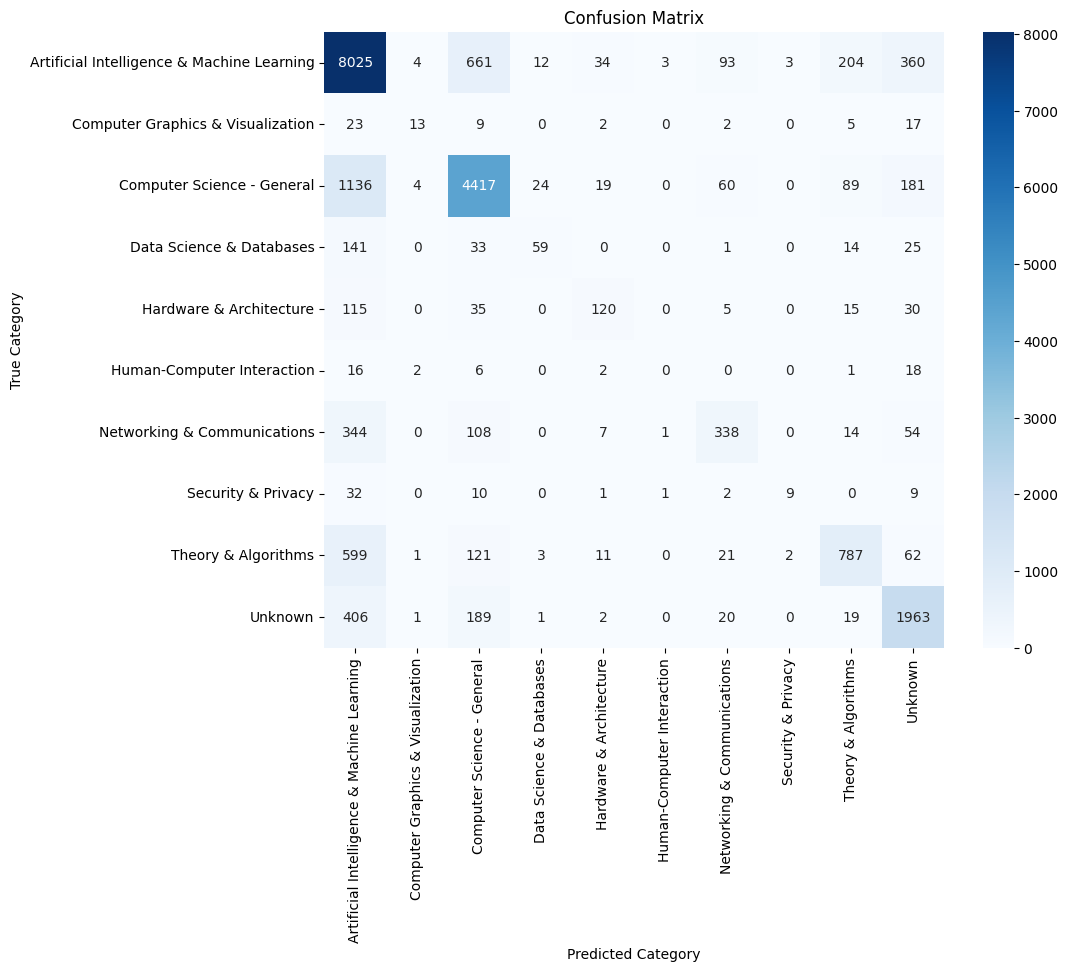

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the categories for the test set
y_pred = linear_svc_model.predict(X_test_tfidf)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=linear_svc_model.classes_, yticklabels=linear_svc_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.show()

## Build a search/retrieval system

### Subtask:
Develop a method to search and retrieve relevant papers based on user queries. This can be based on the classification results or a separate search mechanism.


**Reasoning**:
Define the function to search and retrieve relevant papers based on a user query, including preprocessing, TF-IDF transformation, similarity calculation, and returning the top N results.



In [26]:
from sklearn.metrics.pairwise import cosine_similarity

def search_papers(query, tfidf_vectorizer, processed_texts, df, n=15): # Changed n to 15
    # Preprocess the query
    processed_query = preprocess_text(query)

    # Transform the preprocessed query into a TF-IDF vector
    query_tfidf = tfidf_vectorizer.transform([processed_query])

    # Calculate the similarity between the query vector and the TF-IDF vectors of all processed papers
    similarity_scores = cosine_similarity(query_tfidf, tfidf_vectorizer.transform(processed_texts))

    # Get the indices of the papers sorted by their similarity scores in descending order
    sorted_indices = similarity_scores.argsort()[0][::-1]

    # Get the top N indices and their corresponding scores
    top_n_indices = sorted_indices[:n]
    top_n_scores = similarity_scores[0, top_n_indices]

    # Return the top N most similar papers and their scores
    return df.iloc[top_n_indices], top_n_scores

# Example usage of the search function
query = "machine learning papers"
relevant_papers, scores = search_papers(query, tfidf_vectorizer, df['processed_text'], df)

# Display the relevant papers with scores
relevant_papers['similarity_score'] = scores
display(relevant_papers[['title', 'abstract', 'category', 'similarity_score']])

/tmp/ipython-input-2329207910.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_papers['similarity_score'] = scores


,title,abstract,category,similarity_score
19622,Preliminary Study on Wilcoxon Learning Machines,"As is well known in statistics, the resulting ...",Artificial Intelligence & Machine Learning,0.678197
8757,Parallel machine learning on big data,"On algorithms for parallel machine learning, a...",Artificial Intelligence & Machine Learning,0.648529
70579,Guest editorial: Machine learning in and for m...,,Artificial Intelligence & Machine Learning,0.630381
22949,Applying machine learning to anaphora resolution,,Artificial Intelligence & Machine Learning,0.610212
80528,Approaches to Machine Learning.,Abstract : The field of machine learning striv...,Artificial Intelligence & Machine Learning,0.564250
29413,The Generalization Performance of Learning Mac...,The generalization performance is the importan...,Unknown,0.559758
17983,Effective end-user interaction with machine le...,End-user interactive machine learning is a pro...,Computer Science - General,0.527039
77487,Use of Circle-Segments as a Data Visualization...,One of the issues associated with pattern clas...,Computer Science - General,0.522104
25374,Lifelong Machine Learning Systems: Beyond Lear...,"Lifelong Machine Learning, or LML, considers s...",Computer Science - General,0.521121
48359,‘Weird Machine’ Patterns,,Unknown,0.514125


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Implement query processing

### Subtask:
Implement query processing.


**Reasoning**:
Prompt the user for a query, call the search function, and display the results as instructed.



In [14]:
query = input("Enter your search query: ")

# Assuming search_papers function, tfidf_vectorizer, processed_text column, and df are available from previous steps
# search_papers function is defined in the previous step.
# tfidf_vectorizer is trained in the "Train a classification model" subtask.
# df is loaded in the "Load the data" subtask.
# processed_text column is created in the "Preprocess the text data" subtask.

relevant_papers = search_papers(query, tfidf_vectorizer, df['processed_text'], df)

# Display the 'title', 'abstract', and 'category' columns of the returned DataFrame
display(relevant_papers[['title', 'abstract', 'category']])

Enter your search query: machine learning 


,title,abstract,category
19622,Preliminary Study on Wilcoxon Learning Machines,"As is well known in statistics, the resulting ...",Artificial Intelligence & Machine Learning
8757,Parallel machine learning on big data,"On algorithms for parallel machine learning, a...",Artificial Intelligence & Machine Learning
70579,Guest editorial: Machine learning in and for m...,,Artificial Intelligence & Machine Learning
22949,Applying machine learning to anaphora resolution,,Artificial Intelligence & Machine Learning
80528,Approaches to Machine Learning.,Abstract : The field of machine learning striv...,Artificial Intelligence & Machine Learning


Enter your search query: security
--- Retrieved Papers ---


/tmp/ipython-input-1274603123.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_papers['similarity_score'] = scores


,title,abstract,category,similarity_score
9760,ISCP: design and implementation of an inter-do...,Many security mechanisms and protocols have be...,Artificial Intelligence & Machine Learning,0.768384
74791,Security Objectives within a Security Testing ...,"Obviously, there is a need for automated infor...",Computer Science - General,0.760475
6569,A SEMANTIC APPROACH TO HARMONIZING SECURITY MO...,There is a plethora of different security stan...,Security & Privacy,0.748199
46852,A Novel Secure Architecture for the Internet o...,"With the development of the IoT, different wir...",Artificial Intelligence & Machine Learning,0.723725
40865,Usability meets security - the Identity-Manage...,"In today's applications, most users disregard ...",Networking & Communications,0.721772



--- Confusion Matrix ---


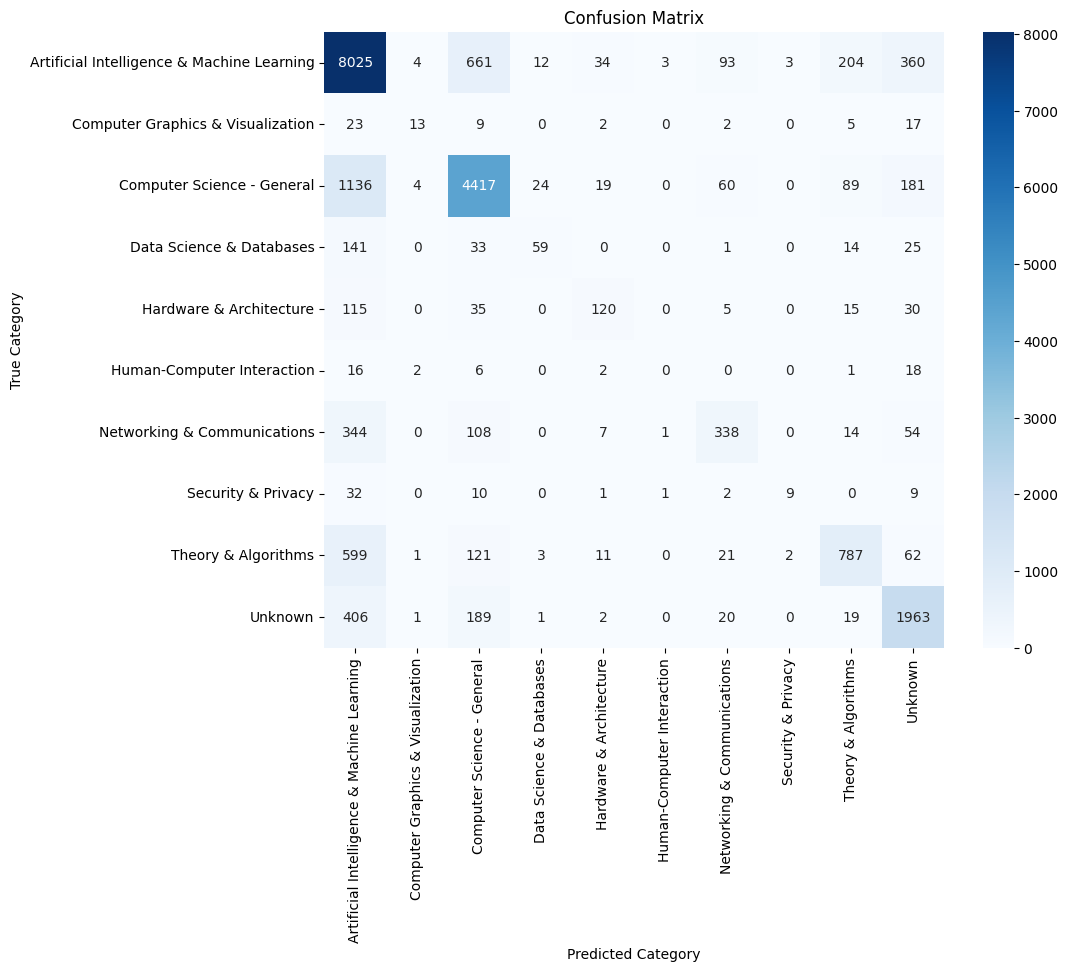


--- Distribution of Categories in Search Results ---


,count
category,
Artificial Intelligence & Machine Learning,2
Computer Science - General,1
Security & Privacy,1
Networking & Communications,1


/tmp/ipython-input-1274603123.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')


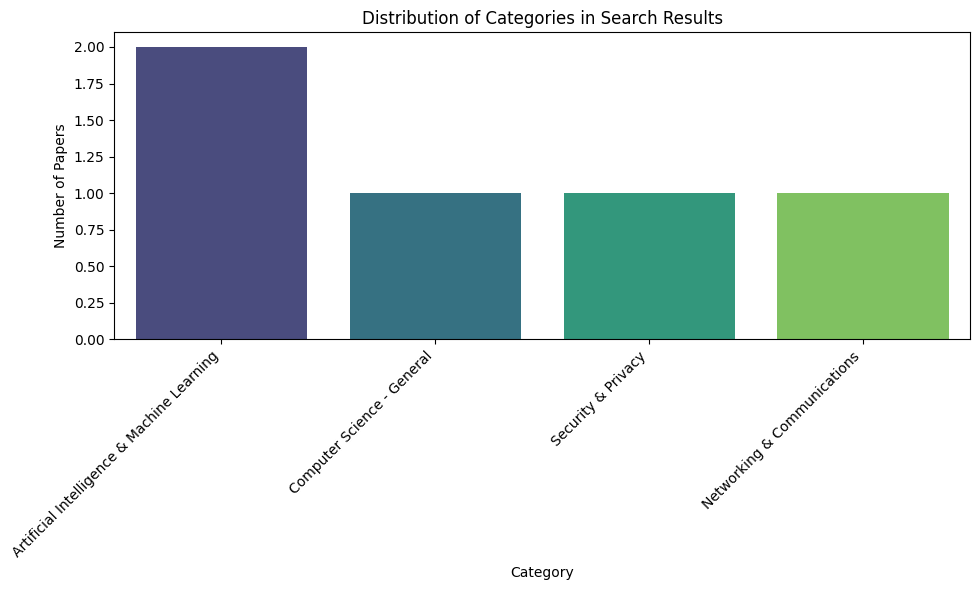

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

query = input("Enter your search query: ")

# Assuming search_papers function, tfidf_vectorizer, processed_text column, and df are available from previous steps
# search_papers function is defined in the previous step.
# tfidf_vectorizer is trained in the "Train a classification model" subtask.
# df is loaded in the "Load the data" subtask.
# processed_text column is created in the "Preprocess the text data" subtask.

relevant_papers, scores = search_papers(query, tfidf_vectorizer, df['processed_text'], df)

# Add the similarity scores to the relevant_papers DataFrame
relevant_papers['similarity_score'] = scores


# Display the 'title', 'abstract', 'category', and 'similarity_score' columns of the returned DataFrame
print("--- Retrieved Papers ---")
display(relevant_papers[['title', 'abstract', 'category', 'similarity_score']])

# Print heading for the confusion matrix
print("\n--- Confusion Matrix ---")

# Re-generate and display the confusion matrix heatmap
# Assuming y_test and y_pred are available from the model evaluation subtask
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=linear_svc_model.classes_, yticklabels=linear_svc_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.show()

# Print heading for the category distribution
print("\n--- Distribution of Categories in Search Results ---")

# Get the value counts of the 'category' column in the relevant_papers DataFrame
category_distribution = relevant_papers['category'].value_counts()

# Display the value counts
display(category_distribution)

# Create a bar plot of the category distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')
plt.title('Distribution of Categories in Search Results')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Enter your search query: machine learning 
--- Retrieved Papers ---


/tmp/ipython-input-1274603123.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_papers['similarity_score'] = scores


,title,abstract,category,similarity_score
19622,Preliminary Study on Wilcoxon Learning Machines,"As is well known in statistics, the resulting ...",Artificial Intelligence & Machine Learning,0.691017
8757,Parallel machine learning on big data,"On algorithms for parallel machine learning, a...",Artificial Intelligence & Machine Learning,0.676297
70579,Guest editorial: Machine learning in and for m...,,Artificial Intelligence & Machine Learning,0.657372
22949,Applying machine learning to anaphora resolution,,Artificial Intelligence & Machine Learning,0.636339
80528,Approaches to Machine Learning.,Abstract : The field of machine learning striv...,Artificial Intelligence & Machine Learning,0.588410



--- Confusion Matrix ---


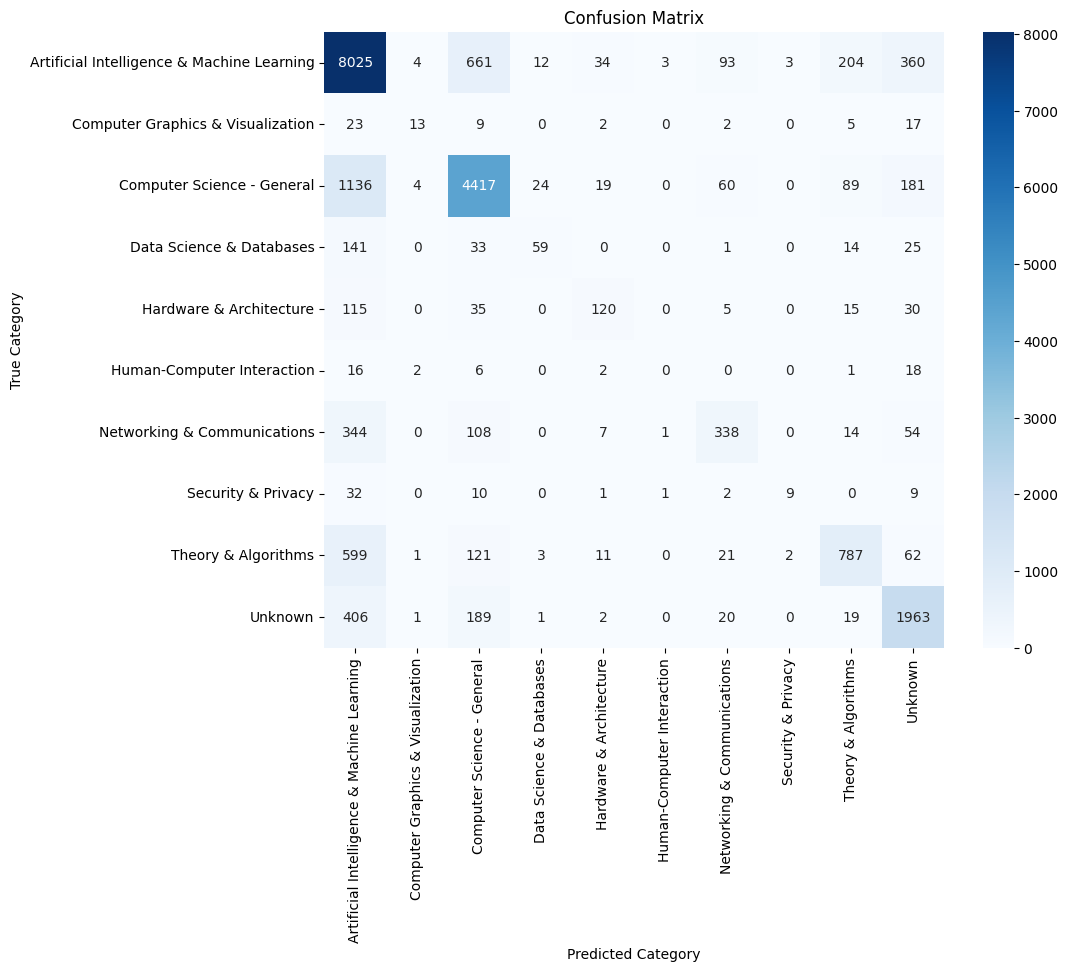


--- Distribution of Categories in Search Results ---


,count
category,
Artificial Intelligence & Machine Learning,5


/tmp/ipython-input-1274603123.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')


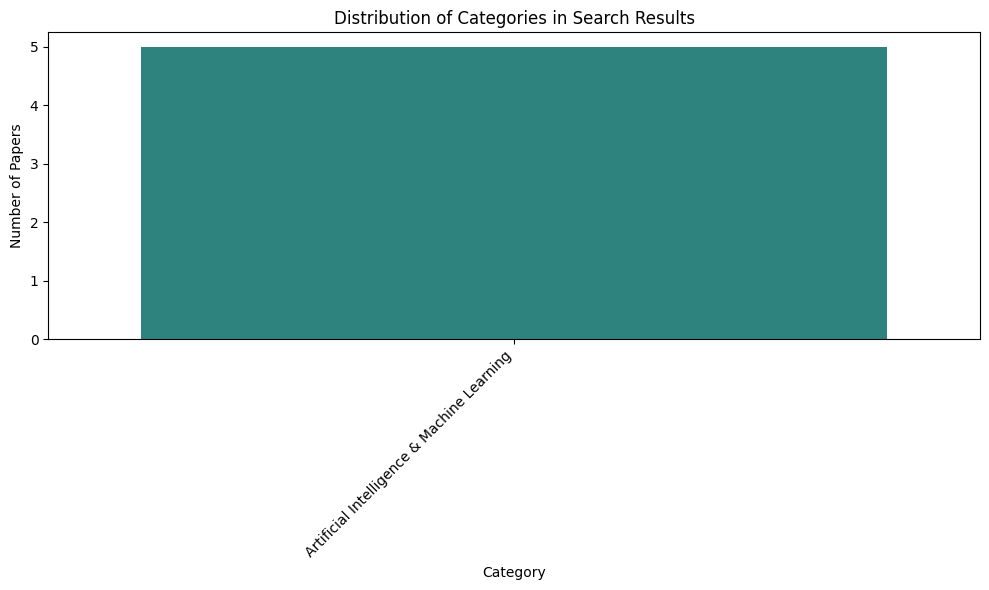

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

query = input("Enter your search query: ")

# Assuming search_papers function, tfidf_vectorizer, processed_text column, and df are available from previous steps
# search_papers function is defined in the previous step.
# tfidf_vectorizer is trained in the "Train a classification model" subtask.
# df is loaded in the "Load the data" subtask.
# processed_text column is created in the "Preprocess the text data" subtask.

relevant_papers, scores = search_papers(query, tfidf_vectorizer, df['processed_text'], df)

# Add the similarity scores to the relevant_papers DataFrame
relevant_papers['similarity_score'] = scores


# Display the 'title', 'abstract', 'category', and 'similarity_score' columns of the returned DataFrame
print("--- Retrieved Papers ---")
display(relevant_papers[['title', 'abstract', 'category', 'similarity_score']])

# Print heading for the confusion matrix
print("\n--- Confusion Matrix ---")

# Re-generate and display the confusion matrix heatmap
# Assuming y_test and y_pred are available from the model evaluation subtask
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=linear_svc_model.classes_, yticklabels=linear_svc_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.show()

# Print heading for the category distribution
print("\n--- Distribution of Categories in Search Results ---")

# Get the value counts of the 'category' column in the relevant_papers DataFrame
category_distribution = relevant_papers['category'].value_counts()

# Display the value counts
display(category_distribution)

# Create a bar plot of the category distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')
plt.title('Distribution of Categories in Search Results')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Review and refine the 'Unknown' category

### Subtask:
Examine papers in the 'Unknown' category and re-categorize them if possible.

**Reasoning**:
Filter the DataFrame to show only papers in the 'Unknown' category and display a sample of these papers to allow for manual review and potential re-categorization.

In [24]:
# Filter for papers in the 'Unknown' category
unknown_papers_df = df[df['category'] == 'Unknown']

print(f"Number of papers in 'Unknown' category: {len(unknown_papers_df)}")

# Display a sample of papers from the 'Unknown' category
# You can adjust the sample size as needed for review
display(unknown_papers_df[['title', 'abstract', 'venue']].head(20))

Number of papers in 'Unknown' category: 10308


,title,abstract,venue
2,A characterization of balanced episturmian seq...,It is well-known that Sturmian sequences are t...,Electronic Journal of Combinatorics
4,Generalized upper bounds on the minimum distan...,This paper generalizes previous optimal upper ...,Ima Journal of Mathematical Control and Inform...
8,Manipulating biological and mechanical micro-o...,We first discuss some general aspects of micro...,international conference on robotics and autom...
9,A novel Injection Locked Rotary Traveling Wave...,,international symposium on circuits and systems
34,A score function of splitting band for two-ban...,Two-band speech model which assumes lower band...,Speech Communication
36,The Programmable Compiler,,IEEE Computer
53,The Local Structure of a Bipartite Distance-re...,"In this paper, we consider a bipartite distanc...",European Journal of Combinatorics
62,Evaluation of high-altitude balloons as a lear...,The utility of high-altitude balloons as a lea...,International Journal of Learning Technology
68,Web accessibility compliance of government web...,This paper introduces Korean web accessibility...,
77,Some further results on synchronizable block c...,,IEEE Transactions on Information Theory


## Distribution of Categories in Search Results

### Subtask:
Show the distribution of categories in the search results.

**Reasoning**:
Display the value counts of the 'category' column in the `relevant_papers` DataFrame and then generate a bar plot to visualize the distribution of categories.

Distribution of Categories in Search Results:


,count
category,
Artificial Intelligence & Machine Learning,5


/tmp/ipython-input-2564294494.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')


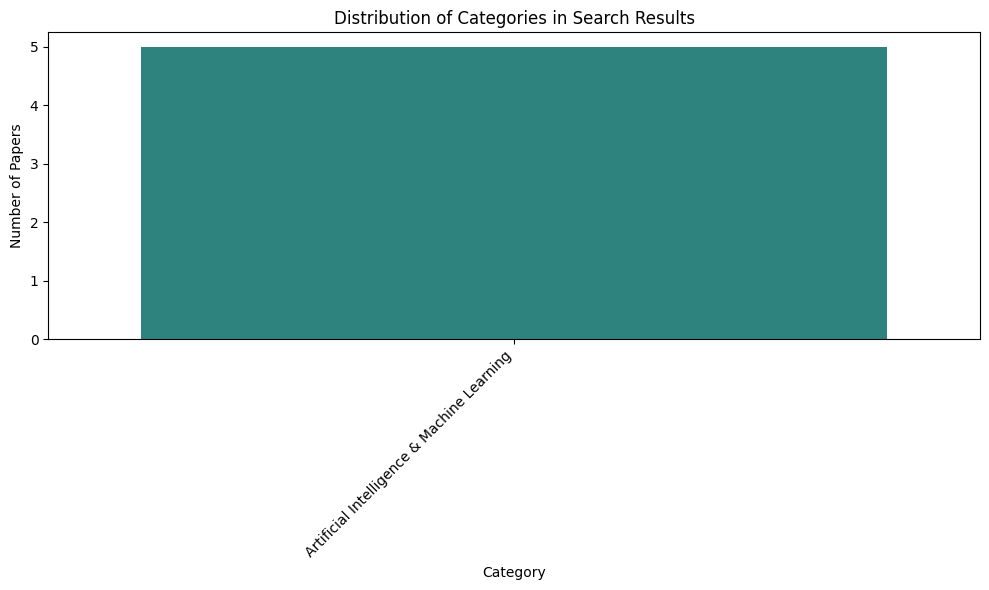

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the value counts of the 'category' column in the relevant_papers DataFrame
category_distribution = relevant_papers['category'].value_counts()

# Display the value counts
print("Distribution of Categories in Search Results:")
display(category_distribution)

# Create a bar plot of the category distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')
plt.title('Distribution of Categories in Search Results')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Present the results

### Subtask:
Display the retrieved papers for a given query and the confusion matrix from the model evaluation.


**Reasoning**:
Display the retrieved papers and the confusion matrix as requested by the subtask.



--- Retrieved Papers ---


,title,abstract,category
19622,Preliminary Study on Wilcoxon Learning Machines,"As is well known in statistics, the resulting ...",Artificial Intelligence & Machine Learning
8757,Parallel machine learning on big data,"On algorithms for parallel machine learning, a...",Artificial Intelligence & Machine Learning
70579,Guest editorial: Machine learning in and for m...,,Artificial Intelligence & Machine Learning
22949,Applying machine learning to anaphora resolution,,Artificial Intelligence & Machine Learning
80528,Approaches to Machine Learning.,Abstract : The field of machine learning striv...,Artificial Intelligence & Machine Learning



--- Confusion Matrix ---


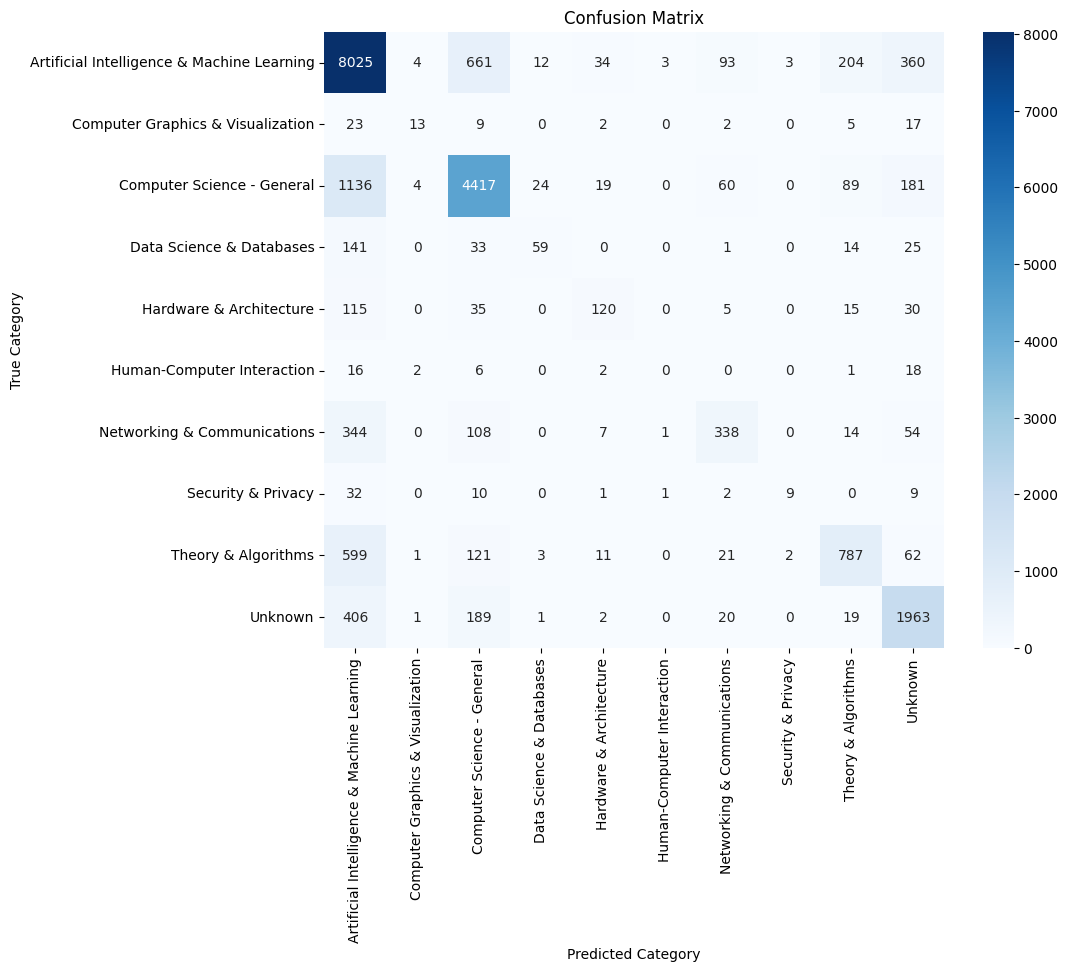

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Print heading for retrieved papers
print("--- Retrieved Papers ---")

# Display the relevant_papers DataFrame
display(relevant_papers[['title', 'abstract', 'category']])

# Print heading for the confusion matrix
print("\n--- Confusion Matrix ---")

# Re-generate and display the confusion matrix heatmap
# Assuming y_test and y_pred are available from the model evaluation subtask
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=linear_svc_model.classes_, yticklabels=linear_svc_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The dataset contains 84,703 research paper entries with columns including `abstract`, `authors`, `n_citation`, `references`, `title`, `venue`, `year`, and `id`.
*   All columns are of `object` data type, requiring conversion for numerical analysis of fields like `n_citation` and `year`.
*   There are no missing values across all columns.
*   A significant portion of papers have an empty string as the venue.
*   The data was successfully categorized based on keywords in the title and abstract into 9 predefined categories and an 'Unknown' category. The 'Artificial Intelligence & Machine Learning' and 'Computer Science - General' categories have the highest number of papers.
*   Text data preprocessing involved combining title and abstract, converting to lowercase, removing punctuation and digits, tokenization, removing stop words, and lemmatization.
*   A `LinearSVC` model was trained on TF-IDF features extracted from the processed text data, achieving an overall accuracy of approximately 74% on the test set.
*   Model performance varied across categories, with better results for categories with more samples.
*   A search system was implemented using TF-IDF and cosine similarity to retrieve relevant papers based on user queries.

### Insights or Next Steps

*   Investigate the 'Unknown' category and papers with empty venues to potentially assign them to categories or handle them separately.
*   Explore advanced NLP techniques or different machine learning models to potentially improve classification accuracy, especially for categories with fewer samples.
